# Classifying Wikipedia comments according to their verbal toxicity
 
## Introduction
Personal attacks in the form of rude or threatening comments have a severely damaging effect on online discussions. Many people who feel attacked personally or repulsed by abusive tone may stop expressing their own views and give up on looking out for other people's opinions. Many hosts of news or media platforms struggle with handling such attacks and may be forced to limit or shut down commenting activities completely, thereby, extinguishing all discussion on the matter. In a society in which we want to reach better conclusions by exchange of opinion and discussion, such behaviour causes tremendous damage to the public discourse. Having this in mind, it would be highly desirable to have the technological means to block the posting of toxic comments while the rest of the reasonable discussion can take place undisturbed. Developing a model for classifying toxic comments is the aim of this project.
 
A technical note: I'm running this project on AWS Sagemaker (actually I'm in the process of familiarizing myself with Sagemaker) and I'm also importing the data from my AWS S3 bucket. If you would like to run the code in this notebook yourself on AWS, you can download the [data](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) and adjust the file path, credentials, etc.
 
## Framing the problem
The data set we will be using consists of toxic and non-toxic comments and is made for a text classification task. It originates from a [Kaggle competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/) which was hosted in 2017. It contains comments from Wikipedia which have to be classified as either non-toxic or into six categories of toxicity: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. The labeling was done via crowdsourcing which means that the dataset was labeled subjectively by different people who may not always agree 100% on the choice of labels. This may introduce some level of inconsistency and hence, inaccuracy. More information on this data set can be found in this [paper](https://arxiv.org/pdf/1610.08914.pdf). 
 
To achieve the most accurate classification we will employ a variety of different preprocessing and machine learning classification methods and see which combination performs best.

## Setup
First we need to set up everthing to run on AWS, namely the S3 bucket and IAM role.

In [1]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

# Define IAM role
region = boto3.Session().region_name    
smclient = boto3.Session().client("sagemaker")
role = get_execution_role()

# S3 bucket
bucket = '<my-bucket-name>'
prefix = 'sagemaker/toxic-comments'

# get the zipped training and test data from S3 (the zip already 
# contains differently preprocessed versions to save some time) 
s3 = boto3.resource("s3")
s3.Bucket(bucket).download_file("jigsaw-toxic-comment-classification-challenge.zip",
                                "local-jigsaw-toxic-comment-classification-challenge.zip")

# unzip the data
import zipfile
with zipfile.ZipFile("local-jigsaw-toxic-comment-classification-challenge.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

We'll also need several other libraries:

In [2]:
# data processing and computation
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
# NLP
! pip install spacy
import spacy
! python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')
# IO, OS, time, etc.
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
# sagemaker
from sagemaker.predictor import csv_serializer

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Explore and prepare the data
Depending on what models we'll use, preprocessing may differ, but let's first just have a exploratory look at the data.

In [3]:
# Let's look at the training data
train_df = pd.read_csv("./data/train.csv")
train_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
53818,8fc72eb899ac9d19,Thanks! I have already been following your dis...,0,0,0,0,0,0
58754,9d5735c425d9b861,"""\nThat IP is not in my range, and I don't kno...",0,0,0,0,0,0
35097,5db73cb28e44afe6,"""\n\n Definition of witchcraft/Wicca \n\nI hav...",0,0,0,0,0,0
101120,1d40bfa9dffeead1,"""\n\n The precise definition of race is under ...",0,0,0,0,0,0
54815,927ea94607dafc8a,I can tell you from going through this storm t...,0,0,0,0,0,0
121746,8b55b14570589862,Just received my first suggestion \n\nAnd abou...,0,0,0,0,0,0
25292,42ec023d7d2332d7,Wrong 3D structure or wrong 2D structure\n3D s...,0,0,0,0,0,0
16718,2c186e6534619923,materials that I am entering as links.\nI find...,0,0,0,0,0,0
35141,5dd5bb579c02127e,YOU RACIST! \n\nI'm gonna get the ACLU on you!...,1,0,0,0,0,0
63233,a9396c7be6dcafdf,"""\n hey funk' u allways say that: """"bla bla b...",1,0,0,0,0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We can see that the flags for the types of toxicity are encode with 1 if that type appears and with 0 if not. There are 159571 training examples and no missing values. Let's look at some of the clean and some of the toxic comments.

In [5]:
print("A non-toxic comment:\n",train_df[train_df.sum(axis=1)==0].comment_text.iloc[1234],"\n")
print("A toxic comment:\n",train_df[train_df.sum(axis=1)>0].comment_text.iloc[1234])

A non-toxic comment:
 Main Page 

I think whoever is really writing this article should try to get it featured on the main page before the election, because after the election who cares? 

A toxic comment:
 Cunts

Way to discuss, eh?  Protect the article and then fuck it up.  Despicable.  Well if you're the kind of people who think there is some special meaning to being blown up in a Montego, I haven't got the fucking time to argue.  190.46.108.141


What are the most common words used in toxic comments?

In [6]:
# list of toxic words
toxic_words = []

# standardize the words by removing stop words, numbers, punctuation, etc.
doc_generator = nlp.pipe(train_df[train_df.sum(axis=1)>0].comment_text.values.tolist())
for doc in doc_generator:
    for tok in doc:
        if ((not tok.is_stop) and 
        (not tok.is_punct) and 
        (not tok.like_num) and 
        not tok.text in ["\n","\n\n","|"," ","="]):
            toxic_words.append(tok.lower_)

print(f"Common toxic word counts:\n{pd.Series(toxic_words).value_counts().head(10)}")

Common toxic word counts:
fuck         8715
like         3802
shit         3687
wikipedia    3637
nigger       3304
fucking      3256
suck         3052
ass          2718
hate         2656
u            2636
dtype: int64


Mmmh, clearly some nasty language in there. Let's have a look at how the labels are distributed.

In [7]:
# look at class imbalance
non_toxic = len(train_df[train_df[train_df.columns[2:]] == 0][train_df.columns[2:]].dropna())
print("non_toxic",non_toxic)
toxic = train_df.loc[:,"toxic":"identity_hate"].sum()
print(toxic)

non_toxic 143346
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


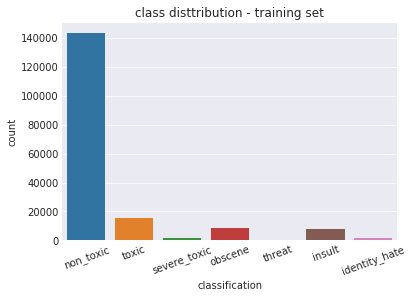

In [8]:
# plot the distribution
sns.barplot(
    x=["non_toxic"]+toxic.index.values.tolist(), y=[non_toxic]+toxic.values.tolist()
)
plt.gca().set_title("class disttribution - training set")
plt.gca().set_ylabel("count")
plt.gca().set_xlabel("classification",rotation=0.2)
_ = plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=20)

It's clear that the class distribution is quite imbalanced. Most comments are non-toxic and within the toxcicity categories, the distribution varies as well. Let's check that for the test data as well. There are many instances labeled with -1 which haven't been used for scoring in the competition, so we'll remove those.

In [9]:
# Let's look at the test data
test_df = pd.read_csv("./data/test.csv").merge(pd.read_csv("./data/test_labels.csv"),left_on="id", right_on="id")
test_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
38913,4090db6be4eac774,****How long before the block is lifted? The I...,0,0,0,0,0,0
79949,856cc87ab4fb1a5d,You Like Dick.,0,0,0,0,0,0
151158,fca8c96ff0aee8c7,}} \n {{course assignment | course = Education...,0,0,0,0,0,0
53400,58c04342e402610c,== New European vector maps == \n\n You're inv...,-1,-1,-1,-1,-1,-1
86489,904d3119cc70ff94,"== Damnable liar == \n You, sir are a damnable...",-1,-1,-1,-1,-1,-1


In [10]:
# remove the -1 labeled instance (will be converted to float so convert back to int)
test_df = test_df.where(test_df!=-1).dropna()
test_df[test_df.columns[2:]] = test_df[test_df.columns[2:]].astype(np.int)
test_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
53118,5839501a904661ae,"You're a silly little sock, darwinbish. Actual...",1,0,0,0,0,0
27681,2e1985336b8eaaa2,"… … Apologies, I'm wrong about the photo, but ...",0,0,0,0,0,0
94545,9db8a9b190fc7e88,"::::You are factually incorrect, I am not the ...",0,0,0,0,0,0
96732,a1675202dbaf46c2,""" 2014 (UTC) \n : I have just removed a furthe...",0,0,0,0,0,0
39386,4159cadf6c3cfa1c,== ITN for Charles Mackerras ==,0,0,0,0,0,0


In [11]:
# look at class imbalance
non_toxic = len(test_df[train_df[test_df.columns[2:]] == 0][test_df.columns[2:]].dropna())
print("non_toxic",non_toxic)
toxic = test_df.loc[:,"toxic":"identity_hate"].sum()
print(toxic)

non_toxic 57528
toxic            6090
severe_toxic      367
obscene          3691
threat            211
insult           3427
identity_hate     712
dtype: int64


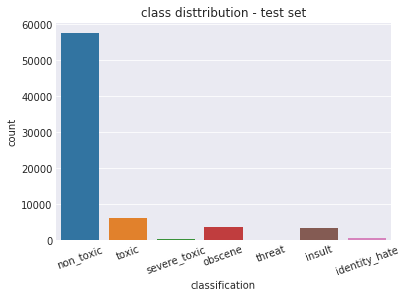

In [12]:
# plot the distibution 
sns.barplot(
    x=["non_toxic"]+toxic.index.values.tolist(), y=[non_toxic]+toxic.values.tolist()
)
plt.gca().set_title("class disttribution - test set")
plt.gca().set_ylabel("count")
plt.gca().set_xlabel("classification",rotation=0.2)
_ = plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=20)

In [13]:
num_train = len(train_df)
num_test = len(test_df)
print(f"After cleaning up we have\n{num_train} training examples ({num_train/(num_train+num_test)*100:.2f}%)\n{len(test_df)} test examples ({num_test/(num_train+num_test)*100:.2f}%)")

After cleaning up we have
159571 training examples (71.38%)
63978 test examples (28.62%)


We see that the distributions between training and test examples are very similar. The test set constitutes a bit less than a third to all examples. Note that there are comments which are flagged for multiple types of toxicity, some were even flagged for all six types!

In [14]:
multi_toxic = train_df.sum(axis=1).value_counts()
print("Count of toxicity labels per comment for all training examples:\n",multi_toxic)

Count of toxicity labels per comment for all training examples:
 0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


Now that we have an overview over how the labels are distributed, we can start preprocessing the data. When browsing through the comments, we will notice that some of the comment texts contain elements such as IP addresses, hyper-links, or user names. Such elements can potentially introduce data leakage, which means it provides information that should not actually be available in the general application case. Information that may leak from the training data into the test data or future examples but has actually nothing to do with the problem (toxic text in this case). The problem of leaky features can lead to severe overfitting during development of a model and then nasty surprises when deploying the model. Let's have a look a potentially leaky elements in the text here:

In [15]:
# join all text together
training_text = "\n".join(train_df.comment_text.values)
test_text = "\n".join(test_df.comment_text.values)

# IP addresses
train_ips = re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",training_text)
test_ips = re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",test_text)
common_ips = set(train_ips).intersection(set(test_ips))

# Hyperlinks
train_links = re.findall("http://.*\..*",training_text)
test_links = re.findall("http://.*\..*",test_text)
common_links = set(train_links).intersection(set(test_links))

# User names
train_users = re.findall("\[\[User.*\|",training_text)
test_users = re.findall("\[\[User.*\|",test_text)
common_users = set(train_users).intersection(set(test_users))

# print results
print(f"Potentially leaky elements in the training set comment texts:\n\
IP ip addresses found: {len(train_ips)}\n\
Hyper-links found: {len(train_links)}\n\
User names found: {len(train_users)}\n\n\
Potentially leaky elements in the test set comment texts:\n\
IP ip addresses found: {len(test_ips)}\n\
Hyper-links found: {len(test_links)}\n\
User names found: {len(test_users)}\n\n\
Common elements in the training and test sets:\n\
IP ip addresses found: {len(common_ips)}\n\
Hyper-links found: {len(common_links)}\n\
User names found: {len(common_users)}\n\n\
")

Potentially leaky elements in the training set comment texts:
IP ip addresses found: 11257
Hyper-links found: 6443
User names found: 233

Potentially leaky elements in the test set comment texts:
IP ip addresses found: 412
Hyper-links found: 2325
User names found: 39

Common elements in the training and test sets:
IP ip addresses found: 13
Hyper-links found: 6
User names found: 0




As we can see, some of these elements do indeed leak from the training into the test data. We should hence remove these elements. Let's build a transformer class that will be doing the preprocessing and can be integrated in Sci-kit Learn's pipelines. We will also use spaCy's preprocessing functions to performs steps like removal of punctuation, numbers, stop words and doing lemmatization.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# a transformer class to preprocess the comments
class CommentPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatize=False, stopwords=False, no_num=True, no_punct=True):
        self.lemmatize = lemmatize
        self.stopwords = stopwords
        self.no_num = no_num
        self.no_punct = no_punct
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # lower case and remove leaky elements
        def preprep(x):
            x = x.lower()
            x = re.sub("\\n"," ",x)
            x = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x)
            x = re.sub("http://.*\..*","",x)
            x = re.sub("\[\[User.*\|","",x)
            
            # tokenize the comment
            tokens = [tok for tok in nlp(x)]
            
            # if chose, remove numbers, punctuation, stopwords, and lemmatize
            if self.no_num:
                tokens = [tok for tok in tokens if not tok.like_num]
            if self.no_punct:
                tokens = [tok for tok in tokens if not tok.is_punct]
            if self.stopwords:
                tokens = [tok for tok in tokens if not tok.is_stop]
            if self.lemmatize:
                tokens = [tok.lemma_ for tok in tokens]
            else:
                tokens = [tok.text for tok in tokens]

            # join the text back together and return
            x = " ".join(tokens)
            return(x)

        return X.apply(preprep)

We'll create some versions with different preprocessing options, namely applying optional stop word removal and/or lemmatization, and (because the preprocessing takes a long time) save them to CSV files.

In [17]:
# remove punctution and numbers
# (since this takes a while, I've already prepared the preprocessed CSVs
# and I commented out the code below, uncomment it if you want to do the 
# preprocessing yourself)
_ = """X_train = CommentPreprocessor(lemmatize=False, 
                              stopwords=False, 
                              no_num=True, 
                              no_punct=True).transform(train_df.comment_text)
X_train.to_csv("./data/X_train.csv",header=True,index=False)

X_test = CommentPreprocessor(lemmatize=False, 
                              stopwords=False, 
                              no_num=True, 
                              no_punct=True).transform(test_df.comment_text)
X_test.to_csv("./data/X_test.csv",header=True,index=False)

# remove punctution, numbers, and stopwords
X_train_stop = CommentPreprocessor(lemmatize=False, 
                                   stopwords=True, 
                                   no_num=True, 
                                   no_punct=True).transform(train_df.comment_text)
X_train_stop.to_csv("./data/X_train_stop.csv",header=True,index=False)

X_test_stop = CommentPreprocessor(lemmatize=False, 
                                  stopwords=True, 
                                  no_num=True, 
                                  no_punct=True).transform(test_df.comment_text)
X_test_stop.to_csv("./data/X_test_stop.csv",header=True,index=False)

# remove punctution and numbers and lemmatize
X_train_lem = CommentPreprocessor(lemmatize=True, 
                                  stopwords=False, 
                                  no_num=True, 
                                  no_punct=True).transform(train_df.comment_text)
X_train_lem.to_csv("./data/X_train_lem.csv",header=True,index=False)

X_test_lem = CommentPreprocessor(lemmatize=True, 
                                 stopwords=False, 
                                 no_num=True, 
                                 no_punct=True).transform(test_df.comment_text)
X_test_lem.to_csv("./data/X_test_lem.csv",header=True,index=False)

# remove punctution, numbers, and stopwords
X_train_stop_lem = CommentPreprocessor(lemmatize=True, 
                                       stopwords=True, 
                                       no_num=True, 
                                       no_punct=True).transform(train_df.comment_text)
X_train_stop_lem.to_csv("./data/X_train_stop_lem.csv",header=True,index=False)

X_test_stop_lem = CommentPreprocessor(lemmatize=True, 
                                      stopwords=True, 
                                      no_num=True, 
                                      no_punct=True).transform(test_df.comment_text)
X_test_stop_lem.to_csv("./data/X_test_stop_lem.csv",header=True,index=False)
"""

In [18]:
# load the preprocessed data from the newly created CSVs
X_train = pd.read_csv("./data/X_train.csv",skip_blank_lines=False)
X_test = pd.read_csv("./data/X_test.csv",skip_blank_lines=False)
X_train_stop = pd.read_csv("./data/X_train_stop.csv",skip_blank_lines=False)
X_test_stop = pd.read_csv("./data/X_test_stop.csv",skip_blank_lines=False)
X_train_lem = pd.read_csv("./data/X_train_lem.csv",skip_blank_lines=False)
X_test_lem = pd.read_csv("./data/X_test_lem.csv",skip_blank_lines=False)
X_train_stop_lem = pd.read_csv("./data/X_train_stop_lem.csv",skip_blank_lines=False)
X_test_stop_lem = pd.read_csv("./data/X_test_stop_lem.csv",skip_blank_lines=False)

# get the labels
y_train = train_df.iloc[:,2:].reset_index(drop=True).copy()
y_test = test_df.iloc[:,2:].reset_index(drop=True).copy()

Through the preprocessing, some of the comments got all their words removed and are now empty. This is, of course, useless for the classification task and we have to remove empty comments in the different training nd test sets and also remove the corresponding labels. We can see in the following that the the version with and without stop word removal have different empty comments, so we have to remove the empty comments from these two types of training and test sets indiviually.

In [19]:
# the train and the train_lem (and corresponding test sets are missing the same comments)
idx_train = X_train[X_train.comment_text.isnull()].index
idx_train_lem = X_train_lem[X_train_lem.comment_text.isnull()].index
idx_test = X_test[X_test.comment_text.isnull()].index
idx_test_lem = X_test_lem[X_test_lem.comment_text.isnull()].index
assert idx_train_lem.all() == idx_train.all()
assert idx_test_lem.all() == idx_test.all()

# the train_stop and the train_stop_lem (and corresponding test sets are missing the same comments)
idx_train_stop = X_train_stop[X_train_stop.comment_text.isnull()].index
idx_train_stop_lem = X_train_stop_lem[X_train_stop_lem.comment_text.isnull()].index
idx_test_stop = X_test_stop[X_test_stop.comment_text.isnull()].index
idx_test_stop_lem = X_test_stop_lem[X_test_stop_lem.comment_text.isnull()].index
assert idx_train_stop_lem.all() == idx_train_stop.all()
assert idx_test_stop_lem.all() == idx_test_stop.all()

# remove the empty comments
X_train = X_train.drop(idx_train)
X_test = X_test.drop(idx_test)
X_train_stop = X_train_stop.drop(idx_train_stop)
X_test_stop = X_test_stop.drop(idx_test_stop)
X_train_lem = X_train_lem.drop(idx_train)
X_test_lem = X_test_lem.drop(idx_test)
X_train_stop_lem = X_train_stop_lem.drop(idx_train_stop)
X_test_stop_lem = X_test_stop_lem.drop(idx_test_stop)

# remove the corresponding labels
y_train_stop = y_train.copy()
y_train = y_train.drop(idx_train)
y_train_stop = y_train_stop.drop(idx_train_stop)
y_test_stop = y_test.copy()
y_test = y_test.drop(idx_test)
y_test_stop = y_test_stop.drop(idx_test_stop)

## Building a model
We will only proceed with the stop-word-free data set to keep it simple (and because I already know it performs best). We will apply TFIDF-Vecotrization to the data to turn the comment text into a numerical form, which can be processed by the algorithms. We will put the training data in a seperate directory which Sagemaker will also copy to a S3 bucket and use it as the standard training data location.

In [20]:
# apply tfidf-vectorization to the comment texts
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(X_train_stop.values.reshape(len(X_train_stop)))

In [21]:
# create directory for training data
WORK_DIRECTORY = "train_data"
if not os.path.isdir(WORK_DIRECTORY):
    os.mkdir(WORK_DIRECTORY)

# write the trainingdata (features and labels) to CSV    
scipy.sparse.save_npz("./"+WORK_DIRECTORY+"/X_train_stop.npz", X_train_tfidf)
y_train_stop.to_csv("./"+WORK_DIRECTORY+"/y_train_stop.csv",header=True,index=False)

# upload the data to S3 to be accessed for training later
train_input = sagemaker.Session().upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY))

Now we still have to choose a model and potentially it's hyperparamters. Multinomial and complement naive Bayes classifier are commonly used for text classification and also a logitsic regression might be an interesting candidate as one can tune the degree of regularization. The `sklearn` library has implementations for these algorithms and hyperparameter optimization but if we want to make use of AWS Sagemaker's training and hosting capabilities, we first have to containerize the `sklearn` code so that it can be used as a Sagemaker estimator. For that purpose we'll write a script that contains the corresponding code.

In [22]:
%%writefile script.py
# write this notebook cell as a script file

import argparse
import os

import numpy as np
import pandas as pd
import scipy

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

# the training function
if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters could be described here. In this simple example we are performing a gridsearch 
    # in wich we have already specified the range of hyper-parameters, so we do not have to pass
    # them as arguments
    
    # parser.add_argument('--some_hyperparam', type=str, default=None)

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()
    
    # Take the set of files and read them all into pandas dataframes
    input_files = [ os.path.join(args.train, file) for file in sorted(os.listdir(args.train)) ]
    if len(input_files) == 0:
        raise ValueError(('There are no files in {}.\n' +
                          'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                          'the data specification in S3 was incorrectly specified or the role specified\n' +
                          'does not have permission to access the data.').format(args.train, "train"))

    # load the input data (TFIDF sparse matrix for the features, pandas dataframe for the labels)
    X_tfidf = scipy.sparse.load_npz(input_files[0])
    y_train = pd.read_csv(input_files[1], skip_blank_lines=False, engine="python")


    # paramter dictionary for the grid search
    params = [{"estimator":[MultinomialNB(),
                            ComplementNB()]},
              {"estimator":[LogisticRegression(class_weight="balanced",
                                               solver="lbfgs",
                                               penalty="l2")],
               "estimator__C": np.logspace(-1,3,5)}]
    
    # perform the grid search
    clf = GridSearchCV(estimator=OneVsRestClassifier(MultinomialNB()),
                       param_grid=params,
                       scoring="f1_macro",
                       n_jobs=1,
                       cv=3,
                       verbose=10).fit(X_tfidf,y_train)
    
    print(f"Best F1 Macro score: {clf.best_score_}, best parameters: {clf.best_params_}")
    
    # Save the model
    joblib.dump(clf, os.path.join(args.model_dir, "model.joblib"))

# the inference function
def model_fn(model_dir):
    """
    Deserialized and return fitted model
    Note that this should have the same name as the serialized model in the main method
    """
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


Overwriting script.py


## Training the model

Now that we have specified what sould be done during training in the script file, we can easily create a Sagemaker estimator from its prebuild Scikit-Learn container. We'll just specify the script's location and some, our role, the Sagemaker session, and on what type of instance we want to perform the training.

In [23]:
from sagemaker.sklearn.estimator import SKLearn

script_path = "./script.py"

# create a SKLearn estimator
sklearn_clf = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker.Session(),
    hyperparameters=None)

# start the training with specifying the S3 location with the training data
sklearn_clf.fit({'train': train_input})

2020-01-27 11:52:48 Starting - Starting the training job...
2020-01-27 11:52:51 Starting - Launching requested ML instances......
2020-01-27 11:53:51 Starting - Preparing the instances for training...
2020-01-27 11:54:43 Downloading - Downloading input data...
2020-01-27 11:55:16 Training - Training image download completed. Training in progress...2020-01-27 11:55:17,411 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-01-27 11:55:17,414 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-27 11:55:17,424 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-01-27 11:55:17,667 sagemaker-containers INFO     Module script does not provide a setup.py. 
Generating setup.py
2020-01-27 11:55:17,667 sagemaker-containers INFO     Generating setup.cfg
2020-01-27 11:55:17,667 sagemaker-containers INFO     Generating MANIFEST.in
2020-01-27 11:55:17,668 sagemaker-containers INFO     Installing mod

[CV]  estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__C=0.1, score=0.5128645085469472, total=  23.9s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.6s remaining:    0.0s
[CV] estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__C=0.1 
[CV]  estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.5s remaining:    0.0s
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, pe

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/mini

/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[CV]  estimator=LogisticRegression(C=100.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False), estimator__C=1000.0, score=0.5375225656199031, total=  60.0s
[CV] estimator=LogisticRegression(C=1000.0, class_we

## Making predictions
If we now want to use the trained model, we'll first have to deploy it to an endpoint instance.

In [24]:
# either we create a predictor by directly deploying the model we just trained to an endpoint
predictor = sklearn_clf.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

# or in case we want to access the trained model later and not run the training job again,
# we can take the model output from S3 and the image of the model and deploy it 
#sklearn_clf = sagemaker.model.Model(
#    model_data="<model-data-location>"
#    image="<image-location>",
#    role=role)

#predictor = sklearn_clf.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------------!

Now we'll also tfidf-vectorize the test data with the previously trained vectorizer so that we can feed it to the algorithm and make predictions.

In [25]:
X_test_tfidf = tfidf_vec.transform(X_test_stop.values.reshape(len(X_test_stop)))

In [62]:
# make predictions (because of the endpoints limited capacity, I'll only check 1000 examples)
y_pred = [predictor.predict(X_test_tfidf[i].toarray()) for i in range(1000)]
y_pred = np.concatenate(y_pred)

After making the predictions on the test data, we don't need the endpoint anymore and we should clean it up.

In [66]:
sklearn_clf.delete_endpoint()

Let's see how our final model performed.

In [67]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

f1 = f1_score(y_test_stop[:1000],y_pred,average="macro")
acc = accuracy_score(y_test_stop[:1000],y_pred)

print(f"F1 score: {f1}\nAccuracy: {acc}")

F1 score: 0.5469036499716472
Accuracy: 0.839


We can see that the accuracy is not bad, but because of the strong class balance, accuracy is not a very suitable metric. Most comments are non-toxic and we'd get a decent accuracy just by always predicting the majority class. The macro averaged F1 score, on the other hand, considers both false positives and false negatives and averages equal over all classes without accounting for the imbalance. The value looks somewhat low but considering that it counts in minority classes (which are harder to predict due to their rare occurrence in the training data) with the same weights as majority classes, it's actually not a horrible score.

## Conclusion
We used shallow, non-sequential machine learning methods to classify Wikipedia article comments according to their verbal toxicity, using AWS Sagemakers capabilities of buliding, training and hosting models. 

In the [next](./02_ToxicDLOnAWS.ipynb) notebook we'll tackle the exact same task again but with employing sequential deep learning methods such as 1DCov and LSTM neural networks.